## Supreme Court Decision Prediction

### Load In Data

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
cases = pd.read_csv('csvs/justice2.csv')
cases2 = pd.read_csv('csvs/justice2.csv')
judges = pd.read_csv('csvs/table_of_justices.csv')
presidents = pd.read_csv('csvs/presidents.csv')

In [3]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          3303 non-null   int64 
 1   ID                  3303 non-null   int64 
 2   name                3303 non-null   object
 3   href                3303 non-null   object
 4   docket              3292 non-null   object
 5   term                3303 non-null   int64 
 6   first_party         3302 non-null   object
 7   second_party        3302 non-null   object
 8   facts               3303 non-null   object
 9   facts_len           3303 non-null   int64 
 10  majority_vote       3303 non-null   int64 
 11  minority_vote       3303 non-null   int64 
 12  first_party_winner  3288 non-null   object
 13  decision_type       3296 non-null   object
 14  disposition         3231 non-null   object
 15  issue_area          3161 non-null   object
dtypes: int64(6), object(10)


In [4]:
judges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Index                     121 non-null    int64 
 1   Justice Name              121 non-null    object
 2   Supreme Court Term Start  121 non-null    object
 3   Supreme Court Term End    121 non-null    object
 4   Appointing President      121 non-null    object
 5   Notable Opinion(s)        121 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.8+ KB


It's nice to note that there isn't any missing information regarding the entered judges here. Every judge has
* Name
* Start Term
* End Term
* Appointing President

This will help us to potentially classify the judge's political affiliations when creating features for our model.

In [6]:
presidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   President   46 non-null     object
 1   Party       46 non-null     object
dtypes: object(2)
memory usage: 868.0+ bytes


### Data Prep

#### Get All Dates in Terms of Years

In [7]:
judges['start_year'] = pd.to_datetime(judges['Supreme Court Term Start']).dt.year
judges['end_year'] = pd.to_datetime(judges['Supreme Court Term End'].replace("--","01-Mar-24")).dt.year

/var/folders/n1/t8qkhtv55nd_gfb_2gwkl_vw0000gn/T/ipykernel_22380/760960972.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  judges['end_year'] = pd.to_datetime(judges['Supreme Court Term End'].replace("--","01-Mar-24")).dt.year


All cases just have a "term" in which a ruling was placed, not an actual date. Therefore, we will need to make an assumption that if a Supreme Court Justice's service encapsulates the term in which a ruling was passed, they will in fact have had been part of that ruling.

#### Match Judges to their Party Affiliations

In [8]:
judges['president_last_name'] = judges["Appointing President"].str.extract(r'^(\w+),')
presidents['president_last_name']= presidents['President '].str.extract(r'\s(\w+)$') 

In [9]:
president_party_dict = presidents.set_index('president_last_name')['Party '].to_dict()
judges['party'] = np.where(judges['president_last_name'].isin(president_party_dict.keys()),
                           judges['president_last_name'].map(president_party_dict),
                           None)
judges['party'] = judges['party'].dropna().apply(lambda x: x.strip())

We make the assumption that the judges will have the same political affiliation as the President that inaugarated him/her. Therefore, it is helpful to map the President's party affiliation to the corresponding Supreme Court Justices they appointed.

In [10]:
judges.value_counts("party")

party
Republican                                   49
Democratic                                   44
Independent                                  11
Democratic-Republican                         6
Republican/National Union                     5
Democratic-Republican/National Republican     4
Whig                                          2
Name: count, dtype: int64

This is a problem that was unforseen. There have been some different sounding political parties over the years with some unique ideals. It's hard to classify distinction with the change of names because...

`Democratic` + `Republican` != `Democratic-Republican`

Our solution here is to instead to map party ideology into "neutral", "conservative", or "liberal" utilizing our pre-existing knowledge of these parties.

In [11]:
ideology_map = {
    "Republican": "conservative",
    "Democratic": "liberal",
    "Independent": "neutral", 
    "Whig": "conservative",
    "Democratic-Republican/National Republican": "conservative",
    "Republican/National Union": "conservative",
    "Democratic-Republican": "liberal"
}

In [12]:
judges['ideology'] = np.where(judges['party'].isin(ideology_map.keys()),
                           judges['party'].map(ideology_map),
                           None)

#### Match Cases to Judges to Get Counts for Each Ideology


In [13]:
cases["conservative"] = 0
cases["liberal"] = 0
cases["neutral"] = 0

In [14]:
for case_index, term in enumerate(cases.term):
    for judge_index, (start, end) in enumerate(zip(judges.start_year, judges.end_year)):
        if (start <= term <= end):
            judge_ideology = judges.ideology[judge_index]
            cases.loc[case_index, judge_ideology] += 1
        else:
            pass

#### Remove Rows Missing "`Issue_area` " and "`first_party_winner`"

In [15]:
cases = cases.loc[cases.issue_area.notnull()]
cases = cases.loc[cases.first_party_winner.notnull()]

#### Regularize Facts Statements

In [16]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    ''' Tokenize document text by stripping the text into individual tokens, removing digit characters, removing punctuation, remove stop words, and lemmatizing the tokens.
    
    Parameters
    ----------
    text : str
        The body of text that you would like to tokenize
    
    Returns
    -------
    cleaned_doc_tokens : str
        The cleaned and tokenized text

    Example
    -------
    text = "Hailey Naugle was quite the important contributor to this Supreme Court analysis. - Brandon Owens"

    clean_text = tokenizer(text)
    
    Will output:
        "hailey naugle important contributor supreme court analysis brandon owens"

    '''

    text_tokens = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        sent_tokens = nltk.word_tokenize(sentence)
        sent_tokens = [lemmatizer.lemmatize(word.lower()) for word in sent_tokens 
                       if (word.lower() not in stop_words) and (word not in string.punctuation) and (len(word) > 1) and not(word.isdigit())]
        text_tokens += sent_tokens

    cleaned_doc_tokens = ' '.join(text_tokens)

    return cleaned_doc_tokens


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/haileynaugle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haileynaugle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/haileynaugle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
cases["cleaned_facts"] = cases["facts"].apply(lambda x: tokenizer(x))

#### Convert Some Columns to Binary

In [18]:
issue_areas = pd.get_dummies(cases.issue_area)
combo_dummies = pd.concat([issue_areas], axis = 1, join="inner")

In [19]:
cols = ["name", "term", "first_party", "second_party", "facts", "cleaned_facts", "majority_vote", "minority_vote", "first_party_winner", "conservative", "liberal", "neutral"]
cases = pd.concat([cases[cols], combo_dummies], axis=1, join="inner")

In [20]:
cases = cases.replace({True: 1, False: 0})

In [21]:
cases.reset_index()

,index,name,term,first_party,second_party,facts,cleaned_facts,majority_vote,minority_vote,first_party_winner,...,Economic Activity,Federal Taxation,Federalism,First Amendment,Interstate Relations,Judicial Power,Miscellaneous,Privacy,Private Action,Unions
0,1,Stanley v. Illinois,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,joan stanley three child peter stanley stanley...,5,2,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Giglio v. United States,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,john giglio convicted passing forged money ord...,7,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Reed v. Reed,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",idaho probate code specified `` male must pref...,7,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Miller v. California,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",miller conducting mass mailing campaign advert...,5,4,1,...,0,0,0,1,0,0,0,0,0,0
4,5,Kleindienst v. Mandel,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,ernest e. mandel belgian professional journali...,6,3,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,3297,Yellen v. Confederated Tribes of the Chehalis ...,2020,"Janet L. Yellen, Secretary of the Treasury",Confederated Tribes of the Chehalis Reservatio...,<p>For over a century after the Alaska Purchas...,century alaska purchase federal government set...,6,3,1,...,0,0,0,0,0,0,0,0,0,0
3155,3298,United States v. Palomar-Santiago,2020,United States,Refugio Palomar-Santiago,"<p>Refugio Palomar-Santiago, a Mexican nationa...",refugio palomar-santiago mexican national gran...,9,0,1,...,0,0,0,0,0,0,0,0,0,0
3156,3299,Terry v. United States,2020,Tarahrick Terry,United States,<p>Tarahrick Terry pleaded guilty to one count...,tarahrick terry pleaded guilty one count posse...,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3157,3300,United States v. Cooley,2020,United States,Joshua James Cooley,<p>Joshua James Cooley was parked in his picku...,joshua james cooley parked pickup truck side r...,9,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
cases.columns

Index(['name', 'term', 'first_party', 'second_party', 'facts', 'cleaned_facts',
       'majority_vote', 'minority_vote', 'first_party_winner', 'conservative',
       'liberal', 'neutral', 'Attorneys', 'Civil Rights', 'Criminal Procedure',
       'Due Process', 'Economic Activity', 'Federal Taxation', 'Federalism',
       'First Amendment', 'Interstate Relations', 'Judicial Power',
       'Miscellaneous', 'Privacy', 'Private Action', 'Unions'],
      dtype='object')

In [23]:
cases['first_party_winner2'] = cases.first_party_winner.astype(int)

In [24]:
cases['ratio_conservative_to_liberal'] = cases.conservative / cases.liberal

cases['ratio_conservative_to_liberal']

1       1.25
2       1.25
3       1.25
4       1.25
5       1.25
        ... 
3297    1.50
3298    1.50
3299    1.50
3300    1.50
3302    1.50
Name: ratio_conservative_to_liberal, Length: 3159, dtype: float64

### EDA

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vectorizer = CountVectorizer()

In [27]:
counts_vectorized = count_vectorizer.fit_transform(cases["cleaned_facts"]) 
counts_array = counts_vectorized.toarray()
counts_df = pd.DataFrame(counts_array, columns = count_vectorizer.vocabulary_.keys())

In [28]:
counts_df

,joan,stanley,three,child,peter,never,married,lived,together,year,...,aquino,aguilera,rios,tarahrick,cooley,saylor,icra,717,717z,penneast
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3159 entries, 1 to 3302
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           3159 non-null   object 
 1   term                           3159 non-null   int64  
 2   first_party                    3158 non-null   object 
 3   second_party                   3158 non-null   object 
 4   facts                          3159 non-null   object 
 5   cleaned_facts                  3159 non-null   object 
 6   majority_vote                  3159 non-null   int64  
 7   minority_vote                  3159 non-null   int64  
 8   first_party_winner             3159 non-null   int64  
 9   conservative                   3159 non-null   int64  
 10  liberal                        3159 non-null   int64  
 11  neutral                        3159 non-null   int64  
 12  Attorneys                      3159 non-null   int64 

Text(0, 0.5, 'count')

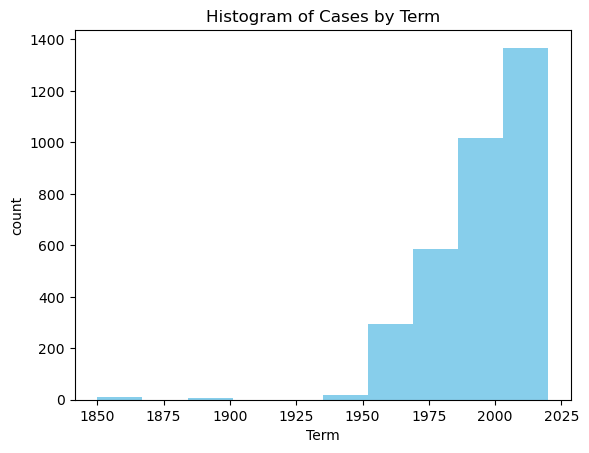

In [30]:
ax = cases2.term.hist(color = 'skyblue', grid = False)
ax.set_title('Histogram of Cases by Term')
ax.set_xlabel('Term')
ax.set_ylabel('count')

From this histogram, we can see that the vast majority of the cases in this data set happened between 1950 and 2023

([<matplotlib.axis.XTick at 0x124fbf810>,
 [Text(0, 0, 'False'), Text(1, 0, 'True')])

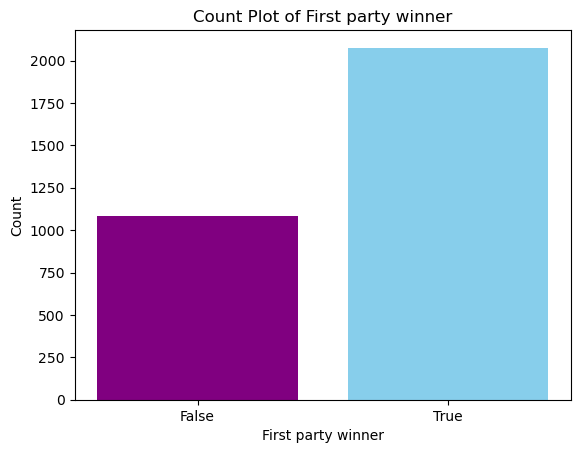

In [31]:
winner_counts = cases.first_party_winner.value_counts()
 

plt.figure()
plt.bar(winner_counts.index, winner_counts, color = ['skyblue', 'purple'])
plt.title('Count Plot of First party winner')
plt.xlabel('First party winner')
plt.ylabel('Count')
plt.xticks( [0,1], [False, True])

In [30]:
cases.first_party_winner.mean()

0.6571699905033238

From the above graph as well as the previous code chunk, we can see that for the majority of these supreme coiurt cases, the appellant wins. This is true for about 66% of the time. 

Now, we want to look at how that percentage changes by issue area:

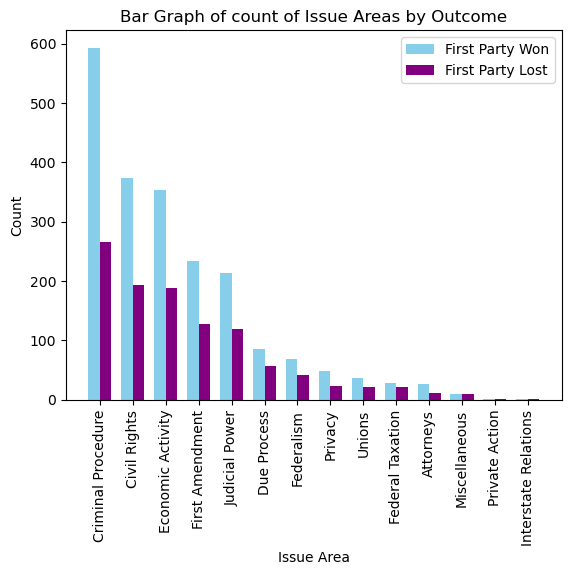

In [31]:
issue_counts = cases2.issue_area.value_counts()
issue_true = cases2[cases2.first_party_winner == True].issue_area.value_counts()
issue_false = cases2[cases2.first_party_winner == False].issue_area.value_counts()

bar_width = 0.35
bar_p1 = np.arange(len(issue_counts.index))
bar_p2 = bar_p1 + bar_width

plt.bar(bar_p1, issue_true, width=bar_width, label='First Party Won', color='skyblue')
plt.bar(bar_p2, issue_false, width=bar_width, label='First Party Lost', color='purple')
plt.xlabel('Issue Area')
plt.ylabel('Count')
plt.xticks(bar_p1 + bar_width/2, issue_counts.index.tolist(), rotation = 90)
plt.title('Bar Graph of count of Issue Areas by Outcome')
plt.legend()
plt.show()

This graph allows us to compare the number of cases in each issue area where the first party won to those where the first party lost. To get the percent of times the first party won for each area, we run to following code:

In [32]:
cases2.groupby(['issue_area'])['first_party_winner'].apply(lambda x: x.mean())

issue_area
Attorneys               0.729730
Civil Rights            0.658451
Criminal Procedure      0.690338
Due Process             0.671875
Economic Activity       0.652495
Federal Taxation        0.568627
Federalism              0.552000
First Amendment         0.662890
Interstate Relations    0.500000
Judicial Power          0.624633
Miscellaneous           0.450000
Privacy                 0.700000
Private Action          0.500000
Unions                  0.616667
Name: first_party_winner, dtype: float64

There seem to be slight differences in the percentages by issue area, these might be significant. We will inculde factor this in future models. 

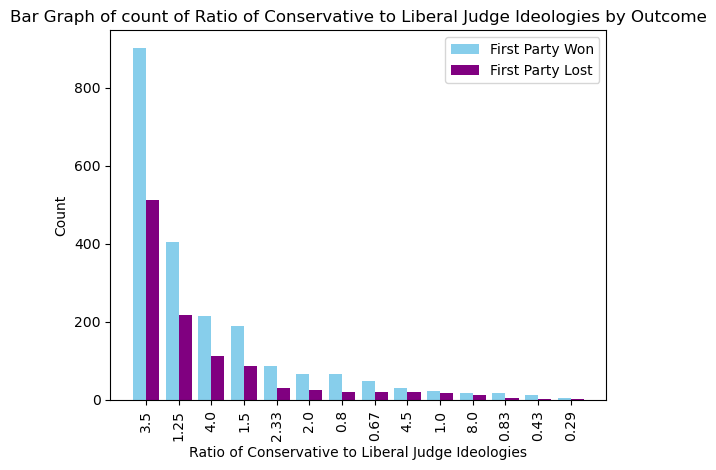

In [33]:
ideology_counts = cases.ratio_conservative_to_liberal.value_counts()
ideology_true = cases[cases.first_party_winner == True].ratio_conservative_to_liberal.value_counts()
ideology_false = cases[cases.first_party_winner == False].ratio_conservative_to_liberal.value_counts()

bar_width = 0.4
bar_p1 = np.arange(len(ideology_counts.index))
bar_p2 = bar_p1 + bar_width
loc = bar_p1 + bar_width/2
rounded_ideology_ratios = [round(x,2) for x in ideology_counts.index.tolist()] 


plt.bar(bar_p1, ideology_true, width=bar_width, label='First Party Won', color='skyblue')
plt.bar(bar_p2, ideology_false, width=bar_width, label='First Party Lost', color='purple')
plt.xlabel('Ratio of Conservative to Liberal Judge Ideologies')
plt.ylabel('Count')
plt.xticks(loc, rounded_ideology_ratios, rotation = 90)
plt.title('Bar Graph of count of Ratio of Conservative to Liberal Judge Ideologies by Outcome')
plt.legend()
plt.show()

In [35]:
cases.groupby(['ratio_conservative_to_liberal'])['first_party_winner'].apply(lambda x: x.mean())

ratio_conservative_to_liberal
0.285714    0.833333
0.428571    0.722222
0.666667    0.691176
0.800000    0.758621
0.833333    0.842105
1.000000    0.578947
1.250000    0.650564
1.500000    0.683636
2.000000    0.733333
2.333333    0.735043
3.500000    0.637456
4.000000    0.657492
4.500000    0.591837
8.000000    0.586207
Name: first_party_winner, dtype: float64

There seem to be slight differences in the percentages by ratio of ideology, these might be significant. We can inculde factor this in future models. 

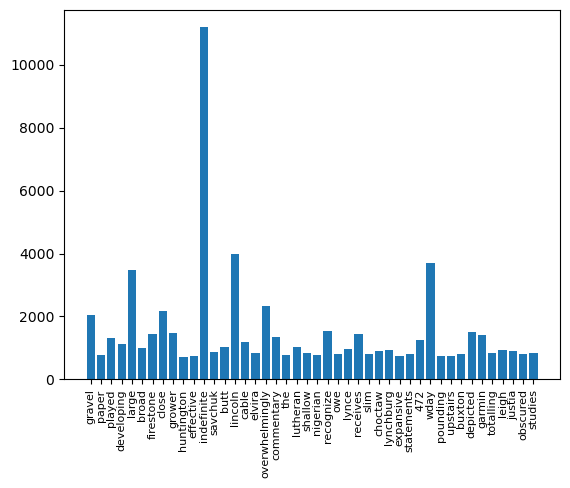

In [115]:
sums = counts_df.sum()

fig, ax = plt.subplots()
ax.bar(sums.index[sums > 700],sums[sums >700])
ax.xaxis.set_tick_params(rotation=90, labelsize = 8)


## Modeling

#### Baseline Model

Since the average of the `first_party_winner` column is greater than 0.5, there are more cases in the dataset where the first party wins. Because of that, we made a null model where we assume the first party always wins. The is the model to which we will compare all subsequent models.

In [36]:
from sklearn.model_selection import train_test_split
cases['null'] = 1
y_predict_train, y_predict_test, ytrain, ytest = train_test_split( cases.null, cases.first_party_winner2, random_state= 27)

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytrain, y_predict_train)


array([[   0,  825],
       [   0, 1544]])

In [38]:

from sklearn.metrics import accuracy_score
accuracy_score(ytrain,y_predict_train)


0.6517517940059097

In [39]:
confusion_matrix(ytest, y_predict_test)

array([[  0, 258],
       [  0, 532]])

In [40]:
accuracy_score(ytest,y_predict_test)

0.6734177215189874

 Here, we see that the accuracy of this null model is around the same for the test and training data at about 66%. The sensitivity of the null model is 1 because it will never predict 0 for the target value and will always catch when it should be a 1. The Specificity is 0 because the null model will always assume 1 for the target value when it should be 0.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#### Features without NLP

In [34]:
features = cases[["term", "conservative", "liberal", "neutral", 'Attorneys', 'Civil Rights', 'Criminal Procedure', 'Due Process',
       'Economic Activity', 'Federal Taxation', 'Federalism',
       'First Amendment', 'Interstate Relations', 'Judicial Power',
       'Miscellaneous', 'Privacy', 'Private Action', 'Unions']]
targets = cases['first_party_winner']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=27)

##### Logistic Regression

In [38]:
clf = LogisticRegression(random_state=27).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6772151898734177

The accuracy of the logistic regression is about 67.7% which is only very slightly better than the null model.

##### Decision Tree

In [45]:
dt = DecisionTreeClassifier(random_state=27).fit(X_train, y_train)
dt.score(X_test, y_test)

0.6044303797468354

The decision tree performed worse than the null model, only achieving about 60% accuracy.

##### Random Forest

In [46]:
rf = RandomForestClassifier(random_state=27).fit(X_train, y_train)
rf.score(X_test, y_test)

0.629746835443038

The random forest, although better than the single decision tree, still performed worse than the null model and logistic regression.

##### K-Nearest Neighbor

In [47]:
knn = KNeighborsClassifier().fit(X_train, y_train)
knn.score(X_test, y_test)

0.5917721518987342

K-nearest neighbor had lower accuracy than all the other models.

#### NLP Extraction without Features

Here, we will run the same models, but this time we will include the `facts` column so that we can use natural language processing to detect patterms in the wording of the case facts

In [44]:
features = cases["cleaned_facts"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=27)

In [46]:
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

##### Logistic Regression

In [42]:
pipe_count_lr = Pipeline(steps=[('cv', CountVectorizer()),('lr', LogisticRegression(solver='liblinear'))])
pipe_tfidf_lr = Pipeline(steps=[('tfidfv', TfidfVectorizer()),('lr', LogisticRegression(solver='liblinear'))])

In [43]:
pipe_count_lr.fit(X_train, y_train)
pipe_count_lr.score(X_test, y_test)

0.6012658227848101

In [53]:
pipe_tfidf_lr.fit(X_train, y_train)
pipe_tfidf_lr.score(X_test, y_test)

0.6819620253164557

##### Decision Tree

In [54]:
pipe_count_dt = Pipeline(steps=[('cv', CountVectorizer()),('dt', DecisionTreeClassifier(random_state=27))])
pipe_tfidf_dt = Pipeline(steps=[('tfidfv', TfidfVectorizer()),('dt', DecisionTreeClassifier(random_state=27))])

In [55]:
pipe_count_dt.fit(X_train, y_train)
pipe_count_dt.score(X_test, y_test)

0.5759493670886076

In [56]:
pipe_tfidf_dt.fit(X_train, y_train)
pipe_tfidf_dt.score(X_test, y_test)

0.5537974683544303

##### Random Forest


In [57]:
pipe_count_rf = Pipeline(steps=[('cv', CountVectorizer()),('rf', RandomForestClassifier(random_state=27))])
pipe_tfidf_rf = Pipeline(steps=[('tfidfv', TfidfVectorizer()),('rf', RandomForestClassifier(random_state=27))])

In [58]:
pipe_count_rf.fit(X_train, y_train)
pipe_count_rf.score(X_test, y_test)

0.6677215189873418

In [59]:
pipe_tfidf_rf.fit(X_train, y_train)
pipe_tfidf_rf.score(X_test, y_test)

0.6566455696202531

##### K-Nearest Neighbors

In [60]:
pipe_count_knn = Pipeline(steps=[('cv', CountVectorizer()),('knn', KNeighborsClassifier())])
pipe_tfidf_knn = Pipeline(steps=[('tfidfv', TfidfVectorizer()),('knn', KNeighborsClassifier())])

In [61]:
pipe_count_knn.fit(X_train, y_train)
pipe_count_knn.score(X_test, y_test)

0.6170886075949367

In [62]:
pipe_tfidf_knn.fit(X_train, y_train)
pipe_tfidf_knn.score(X_test, y_test)

: 

#### Combine BOW Vectors with Features

In [ ]:
facts_count_vectorized = count_vectorizer.fit_transform(cases["cleaned_facts"]) 
dense_counts_vector_array = facts_count_vectorized.toarray()
counts_df = pd.DataFrame(dense_counts_vector_array, columns = count_vectorizer.vocabulary_.keys())

In [ ]:
facts_tfidf_vectorized = tfidf_vectorizer.fit_transform(cases["cleaned_facts"]) 
dense_tfidf_vector_array = facts_tfidf_vectorized.toarray()
tfidf_df = pd.DataFrame(dense_tfidf_vector_array, columns = tfidf_vectorizer.vocabulary_.keys())

In [ ]:
counts_features_df = pd.concat([counts_df, cases], axis=1, join="inner")
tfidf_features_df = pd.concat([tfidf_df, cases], axis=1, join="inner")

In [ ]:
log_reg = LogisticRegression()
rf = RandomForestClassifier()

In [ ]:
unncessary_cols = ["name", "first_party", "second_party", "facts", "cleaned_facts", "majority_vote", "minority_vote", "first_party_winner"]
counts_features = counts_features_df.loc[:, ~counts_features_df.columns.isin(unncessary_cols)]
tfidf_features = tfidf_features_df.loc[:, ~tfidf_features_df.columns.isin(unncessary_cols)]
targets = counts_features_df.loc[:, "first_party_winner"]

In [ ]:
len(targets)

3022

In [ ]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(counts_features, targets, test_size=0.2, random_state=27)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(tfidf_features, targets, test_size=0.2, random_state=27)

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    "penalty":["l1", "l2", "elasticnet"],
    "solver":["lbfgs", "liblinear", "newton-cholesky"],
    "C": [0.01, 0.1, 1, 10],
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=lr_param_grid, cv=5)


In [ ]:
grid_search.fit(Xc_train, yc_train)
best_model_counts = grid_search.best_estimator_
print(grid_search.best_params_)

c:\Users\brand\anaconda3\envs\datasci\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\brand\anaconda3\envs\datasci\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

KeyboardInterrupt: 

In [ ]:
grid_search.fit(Xt_train, yt_train)
best_model_tfidf = grid_search.best_estimator_
print(grid_search.best_params_)